In [65]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
%matplotlib inline

import sys
import os
import yaml
import itertools
sys.path.append('../')
from utils.utils import ModelLoader,DepLoader
from sklearn.externals import joblib
from utils import utils
from matplotlib import pyplot as plt
from timeit import timeit  
from scipy.special import comb, perm
import numpy as np
import pandas as pd
import random
plt.style.use('ggplot')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [2]:
with open('../config/rule_shortdeck_with_holdemrule.yaml') as fhdl:
    cfg = yaml.load(fhdl)

/root/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


In [3]:
env = DepLoader(cfg)

# 手牌规则

In [4]:
keys = list(env.compairer.card5dic.keys())
def is_inrange(inpair,posses):
    instr = ''.join(inpair)
    for one in posses:
        if one in instr:
            return True
    return False 
shortkeys = [i for i in keys if not is_inrange(i,'2345')]
len(shortkeys)

376992

# short deck rules

In [5]:
from utils.deuces_shortdeck import Card,Deck,Evaluator

In [6]:
eva = Evaluator()

In [7]:
colors = 'cdhs'
numbers = '6789TJQKA'

In [8]:
cards = [''.join(i) for i in  list(itertools.product(numbers,colors))]

In [9]:
len(cards)

36

In [10]:
fullcards2rank = {}
with open('../data/card7_dic_sorted_shortdeck.txt','r') as fhdl:
    for line in fhdl:
        one_cards,rank = line.strip().split(',')
        rank = int(rank)
        one_cards = tuple(one_cards.split('-'))
        fullcards2rank[one_cards] = rank
        #whdl.write("{},{}\n".format('-'.join(i),fullcards2rank[i]))

In [11]:
card2rank = {}
with open('../data/card5_dic_sorted_shortdeck.txt','r') as fhdl:
    for line in fhdl:
        one_cards,rank = line.strip().split(',')
        rank = int(rank)
        one_cards = tuple(one_cards.split('-'))
        card2rank[one_cards] = rank
        #whdl.write("{},{}\n".format('-'.join(i),fullcards2rank[i]))

## 校验7张牌和5张牌字典一致性

In [12]:
!du -sh ../data/*.txt

50M	../data/card5_dic_sorted.txt
7.1M	../data/card5_dic_sorted_shortdeck.txt
201M	../data/card7_dic_sorted_shortdeck.txt


# ABSTRACTION - Histogram Of Hand Strength

In [13]:
# TODO finish abstraction

## a naive approach

In [14]:
def get_rank(each):
    hand = [
       Card.new(i) for i in each
    ]
    return evaluator.evaluate([], hand)

In [ ]:
hands = ['7s','7h']

deckcards = cards[:]
for one_card in hands:
    deckcards.remove(one_card)
    
ranks_hist_array = []
combs = list(itertools.combinations(deckcards, 7 - len(hands)))

pb = utils.ProgressBar(worksum=len(combs))
pb.startjob()

ind = 0
for public in combs:
    ind += 1
    board = hands + list(public)
    
    lowest_rank = np.inf
    for one_five_combo in itertools.combinations(board, 5):
        one_five_combo = tuple(sorted(one_five_combo))
        lowest_rank = min(card2rank[one_five_combo],lowest_rank)
        
    opponent_cards = set(deckcards) - set(board)
    oppo_ranks = []
    for one_opponent_prive in itertools.combinations(opponent_cards, len(hands)):
        opponent_board = list(one_opponent_prive) + list(public)
        assert(len(opponent_board) == 7)
        lowest_rank_oppo = np.inf
        for one_five_combo in itertools.combinations(opponent_board, 5):
            one_five_combo = tuple(sorted(one_five_combo))
            lowest_rank_oppo = min(card2rank[one_five_combo],lowest_rank_oppo)
        oppo_ranks.append(lowest_rank_oppo)
    oppo_ranks = np.asarray(oppo_ranks)
    
    prob = np.mean(oppo_ranks > lowest_rank)
    ranks_hist_array.append(prob)
    if ind % 100 == 0:
        pb.complete(100)
        


In [22]:
public,hands,prob

(('6c', '6d', '6h', '6s', '7c'), ['7s', '7h'], 0.0)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f78f8abb3c8>]],
      dtype=object)

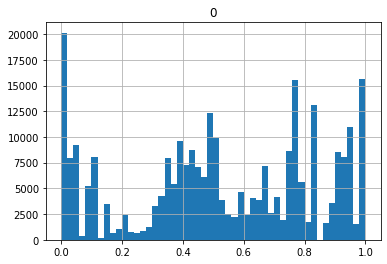

In [180]:
# for ['Ts','Js']
pd.DataFrame(ranks_hist_array).hist(bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f78f00dfc88>]],
      dtype=object)

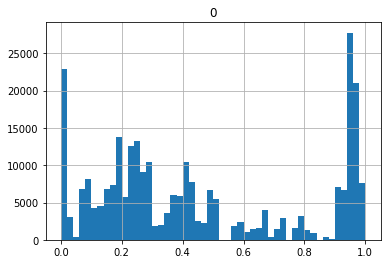

In [175]:
# for ['7s','7h']
pd.DataFrame(ranks_hist_array).hist(bins=50)

# an attempt to accelerate

In [23]:
card2ind = {}
ind2card = {}
for ind,one_card in enumerate(cards):
    card2ind[one_card] = ind
    ind2card[ind] = one_card 

buckets_len = comb(36 -  5,2)
dp_mat = np.zeros([len(cards),int(buckets_len)],dtype = np.int)

deckcards = cards[:]
combs = list(itertools.combinations(deckcards, 5))

In [394]:

private2ranks = {}

pb = utils.ProgressBar(worksum=len(combs))
pb.startjob()

comb_num = 0
for public in combs:
    cards_except_public = set(cards[:]) - set(public)
    cards_except_public = list(cards_except_public)
    
    private_buckets = []
    for one_private in itertools.combinations(cards_except_public,2):
        fullboard = list(one_private) + list(public)
        fullboard = tuple(sorted(fullboard))
        rank = fullcards2rank[fullboard]
        private_buckets.append([sorted(one_private),rank])
        
    
    bucket_ele_number = comb(len(cards_except_public),2)
    private_buckets = sorted(private_buckets,key=lambda x:x[1])[::-1]
    
    ranknum = {}
    beats = {}
    dp_mat -= dp_mat
    
    before_card2num = []
    for ind,(private_hand,rank) in enumerate(private_buckets):
        ranknum.setdefault(rank,0)
        ranknum[rank] += 1
        beat_number = ind + 1 - (float(ranknum[rank]) / 2)
        
        beats.setdefault(rank,0)
        beats[rank] = max(beats[rank],beat_number)
        
        for one_private in private_hand:
            card_ind = card2ind[one_private]
            dp_mat[card_ind,ind] = 1
        if ind > 0:
            dp_mat[:,ind] += dp_mat[:,ind - 1]
    
    percents = []
    for ind,(private_hand,rank) in enumerate(private_buckets):
        #percent = float(ind) / bucket_ele_number # 不能这么除
        # TODO 这个percent仍然不对，没有排除所有手牌中重复的
        sub_num = (sum([dp_mat[card2ind[i],ind - 1] for i in private_hand])) if ind else 0
        percent = (float(beats[rank]) - sub_num ) / (bucket_ele_number - (len(cards) - 5) * 2 + 1)
        
        private_hand = tuple(private_hand)
        private2ranks.setdefault(private_hand,[])
        private2ranks[private_hand].append(percent)
        percents.append(percent)
        
    avg =  np.mean(percents)
    if avg > 0.6 or avg < 0.4:
        raise
        
    comb_num += 1
    if comb_num % 100 == 0:
        pb.info = "avg: {} ".format(avg)
        pb.complete(100)
        

avg: 0.5037128712871286  39.66 % [===================>-------------------------------] 149500/376992 	 used:1347s eta:2050 s

KeyboardInterrupt: 

In [ ]:
hands = ['6s','6h']
probs = private2ranks[tuple(sorted(hands))]
pd.DataFrame(probs).hist(bins=50)
print(np.mean(probs))

0.5667167636455144


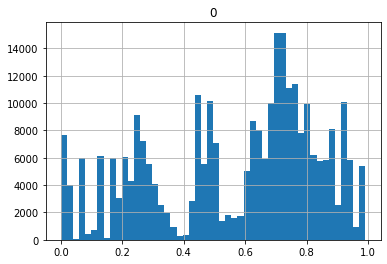

In [338]:
hands = ['Ks','Ad']
probs = private2ranks[tuple(sorted(hands))]
pd.DataFrame(probs).hist(bins=50)
print(np.mean(probs))

0.4047529528003299


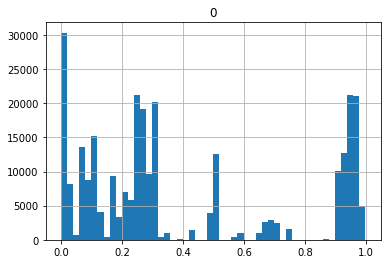

In [306]:
hands = ['6h','6s']
probs = private2ranks[tuple(sorted(hands))]
pd.DataFrame(probs).hist(bins=50)
print(np.mean(probs))

In [343]:
entire_probs = []
hand_prob = []

pb = utils.ProgressBar(worksum = comb(len(cards),2))
pb.startjob()
for hands in itertools.combinations(cards,2):
    probs = private2ranks[tuple(sorted(hands))]
    avg_prob = np.mean(probs)
    entire_probs.append(avg_prob)
    hand_prob.append([hands,avg_prob])
    pb.complete(1)

 100.00 % [==================================================>] 630/630.0 	 used:55s eta:0 s

In [335]:
hand_prob = sorted(hand_prob,key=lambda x:x[1],reverse=True)

## quicker(using process pool)

In [15]:
import multiprocessing
import time

In [16]:
cards = [''.join(i) for i in  list(itertools.product(numbers,colors))]
card2ind = {}
ind2card = {}
for ind,one_card in enumerate(cards):
    card2ind[one_card] = ind
    ind2card[ind] = one_card 

buckets_len = comb(36 -  5,2)

deckcards = cards[:]
combs = list(itertools.combinations(deckcards, 5))

In [21]:
thread_number = 5

pb = utils.ProgressBar(worksum=len(combs) // thread_number) 
pb.startjob()

def process_one_public(inarr):
    public,processed_number = inarr
    cards_except_public = set(cards[:]) - set(public)
    cards_except_public = list(cards_except_public)
    
    private_buckets = []
    for one_private in itertools.combinations(cards_except_public,2):
        fullboard = list(one_private) + list(public)
        fullboard = tuple(sorted(fullboard))
        rank = fullcards2rank[fullboard]
        private_buckets.append([sorted(one_private),rank])
        
    
    bucket_ele_number = comb(len(cards_except_public),2)
    private_buckets = sorted(private_buckets,key=lambda x:x[1])[::-1]
    
    ranknum = {}
    beats = {}
    dp_mat = np.zeros([len(cards),int(buckets_len) + 1],dtype = np.int)
    #dp_mat -= dp_mat
    
    last_diff_index = -1
    before_type_last_index = []
    
    rev_last_diff_ind = len(private_buckets) - 1
    same_type_last_index = []
    for ind,(private_hand,rank) in enumerate(private_buckets):
        rev_ind = len(private_buckets) - 1 - ind
        if rev_ind < len(private_buckets) - 1 and private_buckets[rev_ind][1] != private_buckets[rev_ind + 1][1]:
            rev_last_diff_ind = rev_ind
        same_type_last_index.append(rev_last_diff_ind)
        
        if ind > 0 and rank != private_buckets[ind - 1][1]: # 如果当前元素的rank 和前一个不同
            last_diff_index = ind - 1
        before_type_last_index.append(last_diff_index)
            
        ranknum.setdefault(rank,0)
        ranknum[rank] += 1
        beat_number = ind + 1 - (float(ranknum[rank]) )# TODO add this / 2)
        
        beats.setdefault(rank,0)
        beats[rank] = max(beats[rank],beat_number)
        
        for one_private in private_hand:
            card_ind = card2ind[one_private]
            dp_mat[card_ind,ind] = 1
        if ind > 0:
            dp_mat[:,ind] += dp_mat[:,ind - 1]
            
    before_type_last_index.append(0)
    same_type_last_index = same_type_last_index[::-1]

    results = []
    #print("index\tbeats[rank]\tprivate_hand\tnum_beat")
    for ind,(private_hand,rank) in enumerate(private_buckets):
        #percent = float(ind) / bucket_ele_number # 不能这么除
        # TODO subnum的计算需要在同类型手牌最后一个, beats没有必要, 但是需要加上同类型的去掉手牌中出现牌的牌中的一半
        # same_type_last_index = 同类型手牌最后一个index
        # before_type_last_index = 前面不同类型手牌最后一个index
        # 总beats数量 = beats[rank] - 两个dp_mat[一张手牌,before_type_last_index] ##(这是前面不同rank的有效牌数量)
        #               + { ranknum[rank] - 两个 (dp_mat[一张手牌,same_type_last_index] - 
        #                                   dp_mat[一张手牌,before_type_last_index]  + 3)
        #                 } / 2
        
        ## old solution
        #sub_num = (sum([dp_mat[card2ind[i],ind - 1] for i in private_hand])) if ind else 0
        #print("{}\t{}\t\t{}\t{}".format(ind,beats[rank],private_hand,sub_num))
        #percent = (float(beats[rank]) - sub_num ) / (bucket_ele_number - (len(cards) - 5) * 2 + 1)
        
        last_diff_index = before_type_last_index[ind]
        rev_last_diff_ind = same_type_last_index[ind]
        
        #sub_num = (sum([dp_mat[card2ind[i],last_diff_index] for i in private_hand]))
        #percent = float(last_diff_index + 1 - sub_num) / (bucket_ele_number - (len(cards) - 5) * 2 + 1)
        
        beat_number = beats[rank] - sum([dp_mat[card2ind[i],last_diff_index] for i in private_hand]) \
                    +  (ranknum[rank] -
                         sum([(dp_mat[card2ind[i],rev_last_diff_ind] - dp_mat[card2ind[i],last_diff_index]) \
                           for i in private_hand]) + 2
                    ) / 2
        percent = float(beat_number) / (bucket_ele_number - (len(cards) - 5) * 2 + 1)
        #print("{}\t{}\t\t{}\t{}".format(ind,beats[rank],private_hand,beat_number))
            
        private_hand = tuple(private_hand)
        #private2ranks.setdefault(private_hand,[])
        #private2ranks[private_hand].append(percent)
        results.append((private_hand,percent))
        
    if processed_number % 50 == 0:
        pb.complete(50)
    return results

In [22]:
len(combs)

376992

In [19]:
res = process_one_public((('6c', '6d', '7c', '7d', '9c'),0))

 0.07 % [>--------------------------------------------------] 50/75398 	 used:10s eta:16182 s

In [23]:
private2ranks = {}

starttime = time.time()

pool = multiprocessing.Pool(processes = thread_number)

results = []
for ind,public in enumerate(combs):
    msg = (public,ind)
    one_res = pool.apply_async(process_one_public, (msg, ))   #维持执行的进程总数为processes，当一个进程执行完毕后会添加新的进程进去
    results.append(one_res)
    
print("processing begin")
pool.close()
pool.join()   

for i in range(len(results)):
    results[i] = results[i].get()

endtime = time.time()
print("Total Time Spend : {}".format(endtime - starttime))
pool.terminate()
del pool

processing begin
 106.63 % [=====================================================>] 80400/75398 	 used:771s eta:-47 sTotal Time Spend : 754.6637852191925


In [25]:
len(results)

376992

In [26]:
len(results[0])

465

In [27]:
results[0][0]

(('7d', '7s'), 0.0012376237623762376)

In [28]:
private2ranks = {}

pb = utils.ProgressBar(worksum=len(results)) 
pb.startjob()

ind = 0
for one_result in results:
    ind += 1
    for  (private_hand,percent) in one_result:
        private2ranks.setdefault(private_hand,[])
        private2ranks[private_hand].append(percent)
    if ind % 1000 == 0:
        pb.complete(1000)

 99.74 % [=================================================>-] 376000/376992 	 used:106s eta:0 s

In [48]:
len(private2ranks)

630

0.47798664176189926


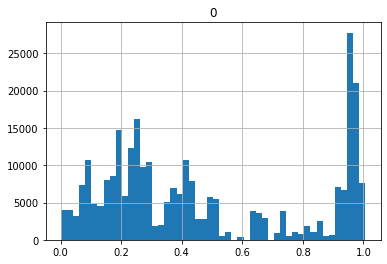

In [42]:
hands = ['7s','7h']
probs = private2ranks[tuple(sorted(hands))]
pd.DataFrame(probs).hist(bins=50)
print(np.mean(probs))

# 对整套牌中 所有轮数 做 abstraction 

In [2]:
with open('../config/abstraction_shortdeck.yaml') as fhdl:
    cfg = yaml.load(fhdl)

/root/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


In [3]:
env = DepLoader(cfg)

In [4]:
deck = env.abstraction_bucket_generator.deck

In [6]:
env.abstraction_bucket_generator.generate_dict_allpublic()

100%|██████████| 376992/376992 [1:32:10<00:00, 68.17it/s] 


In [61]:
env.abstraction_bucket_generator.generate_histrogram(public_card_number=0,bins=50)

100%|██████████| 376992/376992 [04:08<00:00, 1514.64it/s]


<BarContainer object of 50 artists>

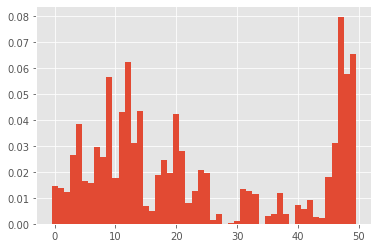

In [72]:
hands = ['7s','7h']
data = env.abstraction_bucket_generator.histdic[tuple(sorted(hands))]
plt.bar(range(len(data)), data,width=1.0)